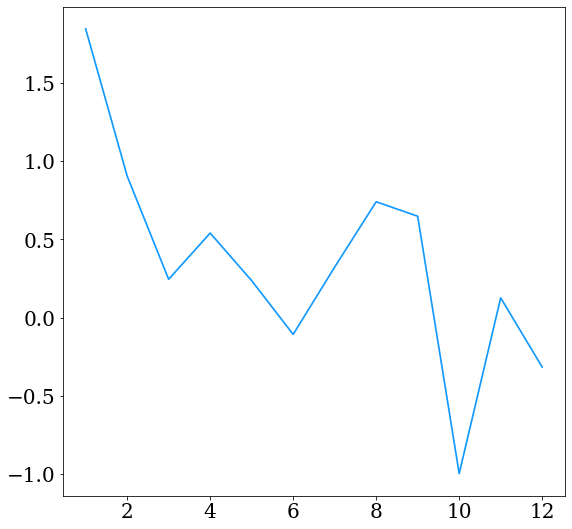

In [9]:
import os.path
import pickle
from pathlib import Path

import autofit as af
from matplotlib import pyplot as plt

from warm_pixels import hst_utilities as ut

data_directory = Path(os.path.abspath("")) / "data"


def load_data(name):
    with open(data_directory / f"{name}.pickle", "r+b") as f:
        return pickle.load(f)


date = load_data("date")
x = load_data("x")
y = load_data("y")
noise = load_data("noise")
n_e = load_data("n_e")
n_bg = load_data("n_bg")
row = load_data("row")

plt.plot(x, y)

In [10]:

"""
We create an analysis class to hold data and compute how good a fit each instance
is. The instance is some callable that given x, n_e, n_bg and row will return a
trail modelled using a set of parameters sampled from parameter space.

The analysis can also use this functionality to visualise the modelled trail and
show how good a match it is.
"""

from autoarray.fit.fit_dataset import SimpleFit


class Analysis(af.Analysis):
    def __init__(self, x, y, noise, n_e, n_bg, row):
        self.x = x
        self.y = y
        self.noise = noise
        self.n_e = n_e
        self.n_bg = n_bg
        self.row = row

    def visualize(self, paths, instance, during_analysis):
        plt.plot(self.x, self.y)
        plt.plot(self.x, instance(
            x=self.x,
            n_e=self.n_e,
            n_bg=self.n_bg,
            row=self.row,
        ))

    def log_likelihood_function(self, instance):
        modelled_trail = instance(
            x=self.x,
            n_e=self.n_e,
            n_bg=self.n_bg,
            row=self.row,
        )
        fit = SimpleFit(
            data=self.y,
            model_data=modelled_trail,
            noise_map=self.noise,
        )
        return fit.log_likelihood

In [11]:
"""
The TrailModel is what we're fitting as we optimise. It's parameterised by the arguments
passed into the constructor (rho_q, beta, w, a, b, c, tau_a, tau_b and tau_c). These
arguments can be constant or they can be a prior if we want the variable to be optimised.

The trail model can be called to recover a modelled trail.
"""

from warm_pixels.hst_functions.trail_model import trail_model


class TrailModel:
    def __init__(
            self,
            rho_q,
            beta,
            w,
            a,
            b,
            c,
            tau_a,
            tau_b,
            tau_c,
    ):
        self.rho_q = rho_q
        self.beta = beta
        self.w = w
        self.a = a
        self.b = b
        self.c = c
        self.tau_a = tau_a
        self.tau_b = tau_b
        self.tau_c = tau_c

    def __call__(self, x, n_e, n_bg, row):
        return trail_model(
            x=x,
            rho_q=self.rho_q,
            n_e=n_e,
            n_bg=n_bg,
            row=row,
            beta=self.beta,
            w=self.w,
            A=self.a,
            B=self.b,
            C=self.c,
            tau_a=self.tau_a,
            tau_b=self.tau_b,
            tau_c=self.tau_c,
        )

In [12]:
"""
For now we're setting constant values for most parameters
"""

# CCD
beta = 0.478
w = 84700.0
# Trap species
a = 0.17
b = 0.45
c = 0.38
# Trap lifetimes before or after the temperature change
if date < ut.date_T_change:
    tau_a = 0.48
    tau_b = 4.86
    tau_c = 20.6
else:
    tau_a = 0.74
    tau_b = 7.70
    tau_c = 37.0

"""
We make a model using the TrailModel type and passing kwargs for each of the constructor arguments.

rho_q is a variable. It can take any value between 0 and 10 with a uniform probability. All the
other arguments are constants.
"""

model = af.Model(
    TrailModel,
    rho_q=af.UniformPrior(
        lower_limit=0.0,
        upper_limit=10.0,
    ),
    beta=beta,
    w=w,
    a=a,
    b=b,
    c=c,
    tau_a=tau_a,
    tau_b=tau_b,
    tau_c=tau_c,
)

2022-10-07 11:23:49,251 - autofit.non_linear.abstract_search - INFO - Creating search
2022-10-07 11:23:49,253 - root - INFO - Starting search
2022-10-07 11:23:49,254 - root - INFO - Saving path info
2022-10-07 11:23:49,254 - root - INFO - Not complete. Starting non-linear search.
2022-10-07 11:23:49,255 - autofit.non_linear.initializer - INFO - Generating initial samples of model, which are subject to prior limits and other constraints.
2022-10-07 11:23:49,265 - root - INFO - No Dynesty samples found, beginning new non-linear search. 


363it [00:01, 241.51it/s, +50 | bound: 5 | nc: 1 | ncall: 2398 | eff(%): 17.223 | loglstar:   -inf < -7.397 <    inf | logz: -11.724 +/-  0.385 | dlogz:  0.001 >  0.059]

2022-10-07 11:23:50,783 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).



363it [00:00, 132061.09it/s, +50 | bound: 5 | nc: 1 | ncall: 2398 | eff(%): 17.223 | loglstar:   -inf < -7.397 <    inf | logz: -11.724 +/-  0.385 | dlogz:  0.001 >  0.059]

2022-10-07 11:23:50,813 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2022-10-07 11:23:50,827 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


2022-10-07 11:23:52,491 - root - INFO - Removing zip file


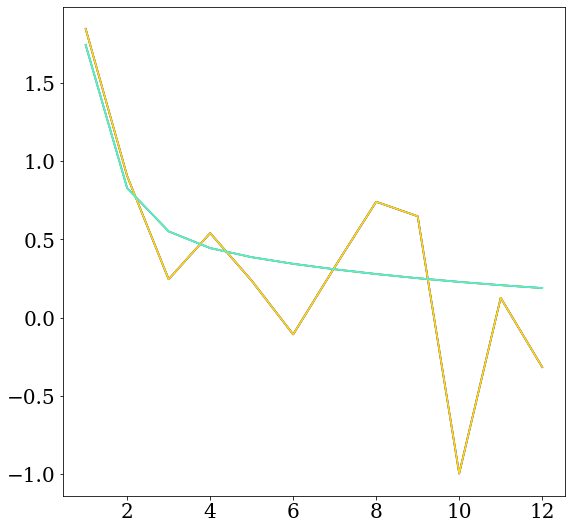

In [13]:
"""
We make an instance of the analysis, passing it the data and associated variables.
"""

analysis = Analysis(
    x=x,
    y=y,
    noise=noise,
    n_e=n_e,
    n_bg=n_bg,
    row=row,
)

"""
We make our optimiser which we can configure
"""

dynesty = af.DynestyStatic()

"""
Optimisation is performed by passing the model and the analysis to the fit function
"""

result = dynesty.fit(
    model=model,
    analysis=analysis,
)

In [15]:
"""
The log likelihood and best parametrisation can be found from the result
"""

print(f"log likelihood = {result.log_likelihood}")

best_trail_model = result.instance

print(f"rho_q = {best_trail_model.rho_q}")

log likelihood = -7.3969661947440875
rho_q = 0.56563844415879
